In [5]:
!pip install pybbn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from pybbn.graph.dag import Bbn
from pybbn.graph.edge import Edge,EdgeType
from pybbn.graph.jointree import EvidenceBuilder
from pybbn.graph.node import BbnNode
from pybbn.graph.variable import Variable
from pybbn.pptc.inferencecontroller import InferenceController

In [7]:
pd.options.display.max_columns=50

In [8]:
df=pd.read_csv('weatherAUS.csv',encoding='utf-8')
df=df[pd.isnull(df['RainTomorrow'])==False]
df=df.fillna(df.mean())
df['WindGustSpeedCat']=df['WindGustSpeed'].apply(lambda x: '0.<=40' if x<=40 else 
                                                    '1.40-50' if 40<x<=50 else '2.>50')
df['Humidity9amCat']=df['Humidity9am'].apply(lambda x: '1.60' if x>60 else '0.<=60')
df['Humidity3pmCat']=df['Humidity3pm'].apply(lambda x: '1.60' if x>60 else '0.<=60')
print(df)


              Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  \
0       01-12-2008   Albury     13.4     22.9       0.6     5.469824   
1       02-12-2008   Albury      7.4     25.1       0.0     5.469824   
2       03-12-2008   Albury     12.9     25.7       0.0     5.469824   
3       04-12-2008   Albury      9.2     28.0       0.0     5.469824   
4       05-12-2008   Albury     17.5     32.3       1.0     5.469824   
...            ...      ...      ...      ...       ...          ...   
145454  20-06-2017    Uluru      3.5     21.8       0.0     5.469824   
145455  21-06-2017    Uluru      2.8     23.4       0.0     5.469824   
145456  22-06-2017    Uluru      3.6     25.3       0.0     5.469824   
145457  23-06-2017    Uluru      5.4     26.9       0.0     5.469824   
145458  24-06-2017    Uluru      7.8     27.0       0.0     5.469824   

        Sunshine WindGustDir  WindGustSpeed WindDir9am WindDir3pm  \
0       7.624853           W           44.0          W        WNW 

<ipython-input-8-c0217f24377c>:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df=df.fillna(df.mean())


In [9]:
def probs(data,child,parent1=None,parent2=None):
  if parent1==None:
    prob=pd.crosstab(data[child],'Empty',margins=False,normalize='columns').sort_index().to_numpy().reshape(-1).tolist()
  elif parent1!=None:
    if parent2==None:
      prob=pd.crosstab(data[parent1],data[child],margins=False,normalize='index').sort_index().to_numpy().reshape(-1).tolist()
    else:
      prob=pd.crosstab([data[parent1],data[parent2]],data[child],margins=False,normalize='index').sort_index().to_numpy().reshape(-1).tolist()
  else: print("Error in Probability Frequency Calculations")
  return prob

In [10]:
H9am=BbnNode(Variable(0,'H9am',['<=60','>60']),probs(df,child='Humidity9amCat'))
H3pm=BbnNode(Variable(1,'H3pm',['<=60','>60']),probs(df,child='Humidity3pmCat',parent1='Humidity9amCat'))
W=BbnNode(Variable(2,'W',['<=40','40-50','>50']),probs(df,child='WindGustSpeedCat'))
RT=BbnNode(Variable(3,'RT',['No','Yes']),probs(df,child='RainTomorrow',parent1='Humidity3pmCat',parent2='WindGustSpeedCat'))


In [11]:
bbn=Bbn() \
     .add_node(H9am) \
     .add_node(H3pm) \
     .add_node(W) \
     .add_node(RT) \
     .add_edge(Edge(H9am,H3pm,EdgeType.DIRECTED)) \
     .add_edge(Edge(H3pm,RT,EdgeType.DIRECTED)) \
     .add_edge(Edge(W,RT,EdgeType.DIRECTED)) 

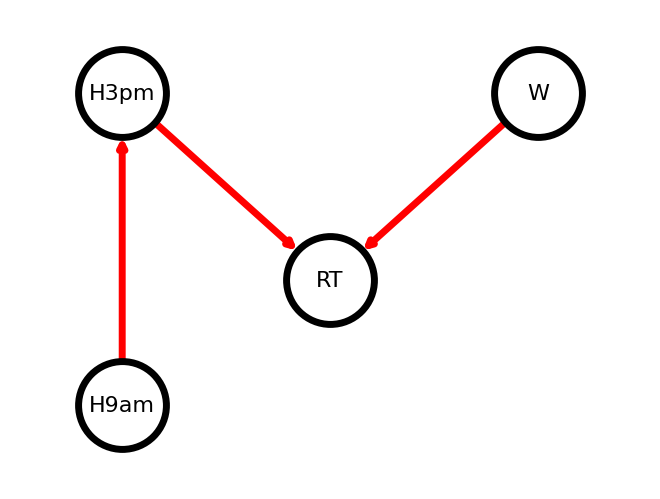

In [13]:
join_tree =InferenceController.apply(bbn)
pos={0: (-1,-2), 1: (-1, 0.5), 2: (1, 0.5), 3:(0,-1)}
options ={
"font_size": 16,
"node_size": 4000,
"node_color": "white",
"edgecolors": "black",
"edge_color": "red",
"linewidths": 5,
"width": 5,
}
n,d=bbn.to_nx_graph()
nx.draw(n, with_labels=True,labels=d, pos=pos, **options)

ax=plt.gca()
ax.margins (0.20)
plt.axis("off")
plt.show()

ValueError: ignored

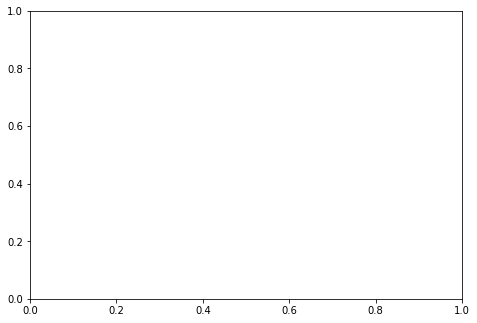